In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.fft import fft, fftfreq
import mne
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level(False)
%matplotlib inline

In [ ]:
def get_level(level):
    if level < 1: return 0
    if level < 2: return 1
    return 2


def band_filter(data, low, high, rate):
    b, a = signal.butter(4, [low, high], btype='band', fs=rate)
    return signal.filtfilt(b, a, data)


def notch_filter(data, freq, rate):
    b, a = signal.iirnotch(freq, 30, fs=rate)
    return signal.filtfilt(b, a, data)


def filter_data(data):
    temp = band_filter(data, 1, 80, 250)
    temp = notch_filter(temp, 50, 250)
    return notch_filter(temp,49, 250)


def read_file(path, meta, mindur=100, srate=250, offset = 0):
    start = offset * 250
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    info = mne.create_info(['channel2', 'channel4'], ch_types=['eeg', 'eeg'], sfreq=srate)
    data = frame.loc[:, ['EXG Channel 2', 'EXG Channel 4']].values.T
    raw = mne.io.RawArray(data[:,start:], info)
    raw = raw.filter(l_freq=1, h_freq=80)
    raw = raw.notch_filter(50)

    duration = np.array([x for _, x in meta]) * srate
    start = np.array([0] + duration.tolist()).cumsum()[:-1]
    middle = np.zeros(start.shape[0], dtype=int)
    types = np.array([get_level(x) for x, _ in meta])

    events = np.stack([start, middle, types], axis=1)
    events = events[duration >= (mindur * srate)]
    return mne.Epochs(raw, events, tmin=20, tmax=mindur, baseline=None)


def select_epochs(data, level):
    epochs = [x[level].get_data(tmin=0, copy=True)[:, :, :-1] for x in data]
    return np.concatenate(epochs, axis=0)


def recursive_variance_estimation(sig, beta=0.9633, theta=50., min_suppr_len=206):
    # beta: forgetting factor. 0.9534 in article with Fs=200Hz
    # tau = -1/(Fs * (ln beta))
    # therefore beta = exp(-1/(tau*Fs))
    # and we have Fs=250 for the TUH EEG data
    # So let's use beta=0.9633
    # theta: threshold for declaring 'suppressed EEG'
    # Recommended approach: use base beta but tune theta for each patient

    # algo can't be vectorized because it is recursive...
    sig = list(sig)
    res = []
    res_var = []
    res_smoothed = []

    # start with mu=0 and sigsquare=0 (this could be improved)
    mu = 0
    sigsquare = 0

    for i in range(len(sig)):
        mu = beta * mu + (1. - beta) * sig[i]
        sigsquare = beta * sigsquare + (1. - beta) * (sig[i] - mu)**2
        res_var += [sigsquare]
        res += [int(not sigsquare < theta)]

    # added compared to original method:
    # smoothing: if a 'suppression' period is shorter than min_suppr
    # samples, delete it
    is_suppressed_keep = False
    for i in range(len(res)):
        if res[i] == 0: # suppressed
            if is_suppressed_keep:
                # we already know that this suppression is long enough and
                # we can keep it
                res_smoothed += [0]
            else:
                # check that enough suppressed samples come after
                if max(res[i:i+min_suppr_len])==0: 
                    res_smoothed += [0]
                    is_suppressed_keep = True
                else:
                    # 'artifact' suppression too short. Consider it not suppressed
                    res_smoothed += [1] 
        else: # not suppressed
            # reset counter
            is_suppressed_keep = False
            res_smoothed += [1]

    return np.array(res), res_smoothed, res_var


def StatDBT(arr):
    d = np.where(np.diff(arr == 1))[0]
    return len(d)


def WindowingBDT(data, theta = 500):
    d = []
    for i in range(len(data)):
        d.append(recursive_variance_estimation(data[i] , theta = theta)[0])
    return np.array(d)


def plot_comparisons(con1, con2, con3, name='Anterior'):
    # Number of comparison for Bonferroni correction
    num_comparisons = 3
    
    # Calculate and adjust p-values between the conditions
    p_value_12 = min(wilcoxon(con1, con2)[1] * num_comparisons, 1.0)  # Cap adjusted p-value at 1
    p_value_13 = min(wilcoxon(con1, con3)[1] * num_comparisons, 1.0)
    p_value_23 = min(wilcoxon(con2, con3)[1] * num_comparisons, 1.0)
    
    # Calculate means and standard errors
    mean1, sem1 = np.mean(con1), np.std(con1) / np.sqrt(len(con1))
    mean2, sem2 = np.mean(con2), np.std(con2) / np.sqrt(len(con2))
    mean3, sem3 = np.mean(con3), np.std(con3) / np.sqrt(len(con3))

    plt.figure(figsize=(5, 5))
    bars = plt.bar(['Low', 'Medium', 'High'], 
                   [mean1, mean2, mean3], 
                   width=0.5, 
                   color=['#73C2FB','#6593F5','#0F52BA'],
                   yerr=[sem1, sem2, sem3], 
                   capsize=11)
    
    # Define y positions for the lines (slightly above the top of the bars)
    y_max = max(mean1 + sem1, mean2 + sem2, mean3 + sem3) + 3
    line_offset = 6  # gap between the bar and the line

    # Add lines and adjusted p-value annotations
    plt.plot([0, 1], [y_max, y_max], color='black', lw=1.5)
    plt.text(0.5, y_max + 2, f'adj p={p_value_12:.4f}', ha='center', fontsize=11)

    plt.plot([0, 2], [y_max + line_offset, y_max + line_offset], color='black', lw=1.5)
    plt.text(1, y_max + line_offset + 2, f'adj p={p_value_13:.4f}', ha='center', fontsize=11)

    plt.plot([1, 2], [y_max + 2*line_offset, y_max + 2*line_offset], color='black', lw=1.5)
    plt.text(1.5, y_max + 2*line_offset + 2, f'adj p={p_value_23:.4f}', ha='center', fontsize=11)
    
    # Additional plot settings
    plt.title(name, size=15)
    plt.ylabel('Suppression Duration (S)', fontsize=15)
    plt.ylim(0, y_max + 3*line_offset + 10)  # adjust the y-limit to give room for p-values and lines

    plt.grid(False)
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    plt.tight_layout(rect=[-0.03, -0.03, 1.03, 1.03])
    
    # Save the plot
    plt.savefig(f"suppresionDuration{name}.pdf", format='pdf', dpi=500)
    plt.savefig(f"suppresionDuration{name}.png", format='png', dpi=500)
    
    plt.show()

def plot_fft_spectrum(low_data, mid_data, high_data, channel, save_path='Anterior'):
    low1 = low_data[-10:, channel].reshape(-1)
    medium1 = mid_data[-10:, channel].reshape(-1)
    high1 = high_data[-10:, channel].reshape(-1)

    sampling_rate = 250
    N = len(low1)
    T = 1 / sampling_rate

    # Frequency values from FFT for slicing up to 20 Hz
    xf = fftfreq(N, T)
    max_freq_idx = np.where(xf <= 20)[0][-1] + 1  # Get index up to 20 Hz

    # FFT for low level isoflurane
    yf1 = fft(low1)
    plt.plot(xf[:max_freq_idx], 2.0 / N * np.abs(yf1[:max_freq_idx]), "-r", alpha=0.5, label="Low Level Isoflurane")

    # FFT for medium level isoflurane
    yf2 = fft(medium1)
    plt.plot(xf[:max_freq_idx], 2.0 / N * np.abs(yf2[:max_freq_idx]), '-b', alpha=0.5, label="Medium Level Isoflurane")

    # FFT for high level isoflurane
    yf3 = fft(high1)
    plt.plot(xf[:max_freq_idx], 2.0 / N * np.abs(yf3[:max_freq_idx]), '-g', alpha=0.5, label="High Level Isoflurane")

    # Plot settings
    plt.ylim(0, 7)
    plt.xlim(0, 20)  # Limit x-axis to 20 Hz
    plt.title(f'FFT Spectrum for Isoflurane Conditions in {save_path} Site', size=15)
    plt.xlabel('Frequency (Hz)', size=17)
    plt.ylabel('Amplitude', size=17)
    plt.grid(False)
    plt.legend(fontsize=11)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(axis='x', labelsize=12)

    # Save plot
    plt.savefig(f'fft{save_path}.pdf', format='pdf', dpi=500)
    plt.savefig(f'fft{save_path}.png', format='png', dpi=500)
    plt.show()



In [4]:
path = 'Dataset-Sleep/1.txt'
meta = [(1, 180), (.6, 120), (.4, 120), (.6, 120), (1, 150), (1.5, 150), (2, 150), (0.2,150)]
data1 = read_file(path, meta)

path = 'Dataset-Sleep/2.txt'
meta = [(1.5, 150), (1, 80), (1.5, 190), (2, 120), (2.5, 160), (2, 120), (1.5, 128), (1, 132), (.6, 126), (.4, 124)]
data2 = read_file(path, meta, offset = 480)

path = 'Dataset-Sleep/3-1.txt'
meta = [(2, 150), (1, 80), (1.5, 190), (2, 120), (2.5, 160), (2, 120), (1.5, 128), (1, 132), (.6, 126), (.4, 124)]
data3 = read_file(path, meta)

path = 'Dataset-Sleep/4-1.txt'
meta = [(1.5, 120), (1, 90), (1.5, 120), (2, 120), (2.5, 120)]
data4 = read_file(path, meta, offset=150)

path = 'Dataset-Sleep/4-2.txt'
meta = [(2, 120), (1.5, 120), (1, 120), (.6, 120), (.4, 120)]
data4 = mne.concatenate_epochs([data4, read_file(path, meta)])

path = 'Dataset-Sleep/5.txt' #5 feb
meta = [(1, 120), (1.5, 120), (2, 120), (1.5, 100), (1, 120), (1.5, 120),(.4, 120),(.6, 120)]
data5 = read_file(path, meta, offset =180)

In [5]:
data = [data1, data2, data3, data4, data5]
low_data = select_epochs(data, '0')
mid_data = select_epochs(data, '1')
high_data = select_epochs(data, '2')

In [6]:
NLC1 = WindowingBDT(low_data[-9:, 0], theta = 70)
NMC1 = WindowingBDT(mid_data[-9:, 0], theta = 70)
NHC1 = WindowingBDT(high_data[-9:, 0], theta =70)

# compute suppression duration in each of isoflurane stages and blocks in channel 1 (anterior)
LC1 = [np.count_nonzero(NLC1[i] == 0)/250 for i in range(len(NLC1)) ] 
MC1 = [np.count_nonzero(NMC1[i] == 0)/250 for i in range(len(NMC1)) ]
HC1 = [np.count_nonzero(NHC1[i] == 0)/250 for i in range(len(NHC1)) ]


In [7]:
NLC2 = WindowingBDT(low_data[-8:, 1], theta = 110)
NMC2 = WindowingBDT(mid_data[-8:, 1], theta = 110)
NHC2 = WindowingBDT(high_data[-8:, 1], theta =110)

# compute suppression duration in each of isoflurane stages and blocks in channel 1 (posterior)
LC2= [np.count_nonzero(NLC2[i] == 0)/250 for i in range(len(NLC2)) ]
MC2 = [np.count_nonzero(NMC2[i] == 0)/250 for i in range(len(NMC2)) ]
HC2 = [np.count_nonzero(NHC2[i] == 0)/250 for i in range(len(NHC2)) ]


In [8]:

stat, p = stats.friedmanchisquare(LC1, MC1, HC1)
stat2, p2 = stats.friedmanchisquare(LC2, MC2, HC2)
print(p, p2)

0.008414677489201218 0.0015034391929775717


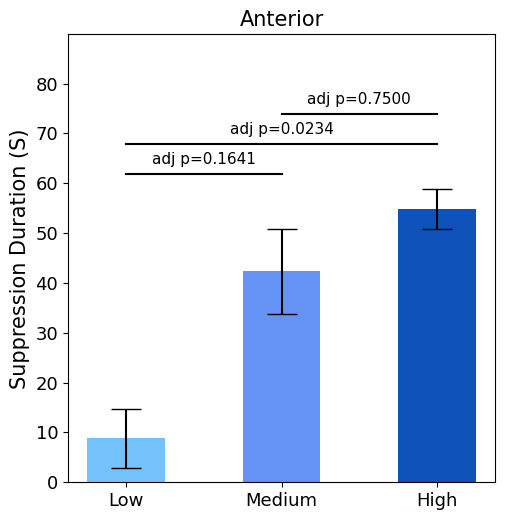

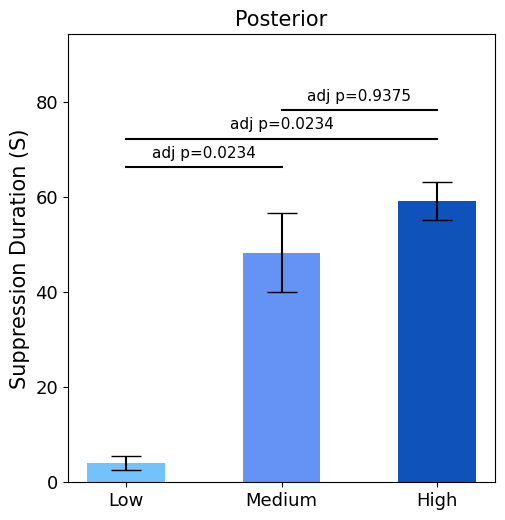

In [9]:
plot_comparisons(LC1, MC1, HC1, name='Anterior')
plot_comparisons(LC2, MC2, HC2, name='Posterior')


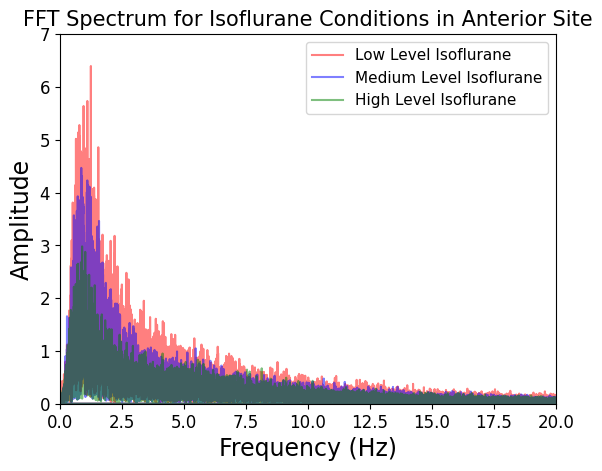

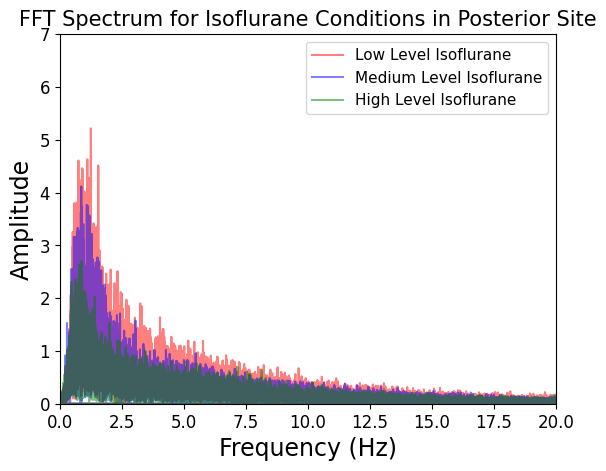

In [11]:
plot_fft_spectrum(low_data, mid_data, high_data, channel = 0, save_path='Anterior')
plot_fft_spectrum(low_data, mid_data, high_data, channel = 1, save_path='Posterior')


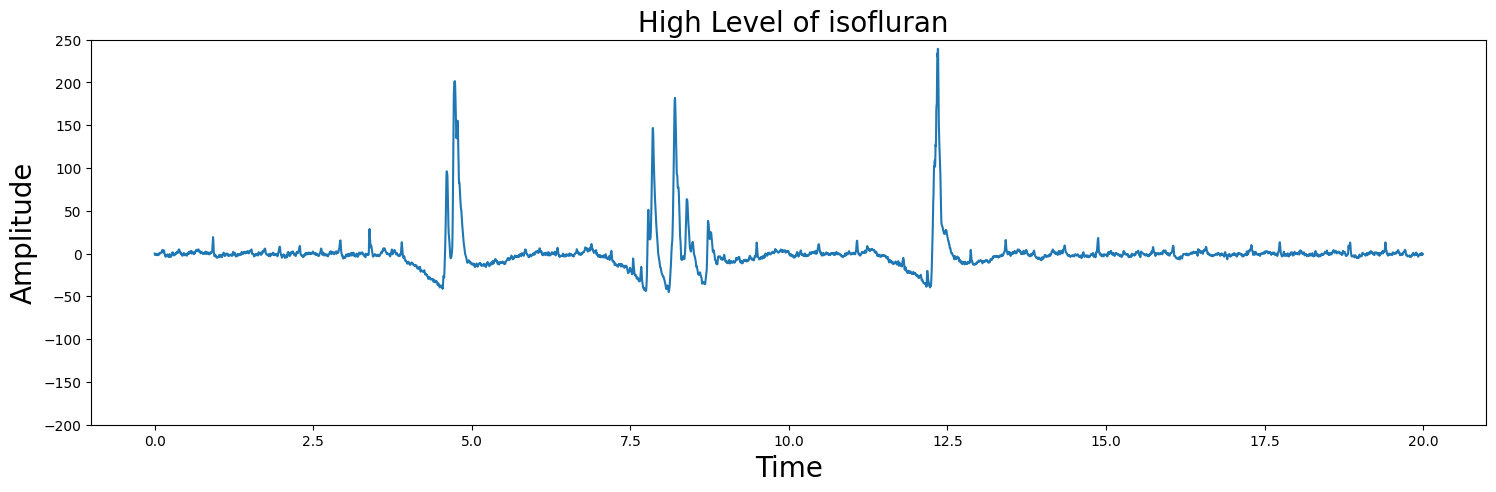

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title(' High Level of isofluran', size = 20)
plt.xlabel('Time', size = 20) 
plt.ylabel('Amplitude', size = 20) 
plt.ylim(-200,250)

plt.plot(np.arange(5000)/250 ,high_data[-5, 1, 2000:7000])
plt.grid(False)

plt.savefig('SampleHigh.pdf', format='pdf', dpi=500)
plt.savefig('SampleHigh.png', format='png', dpi=700)

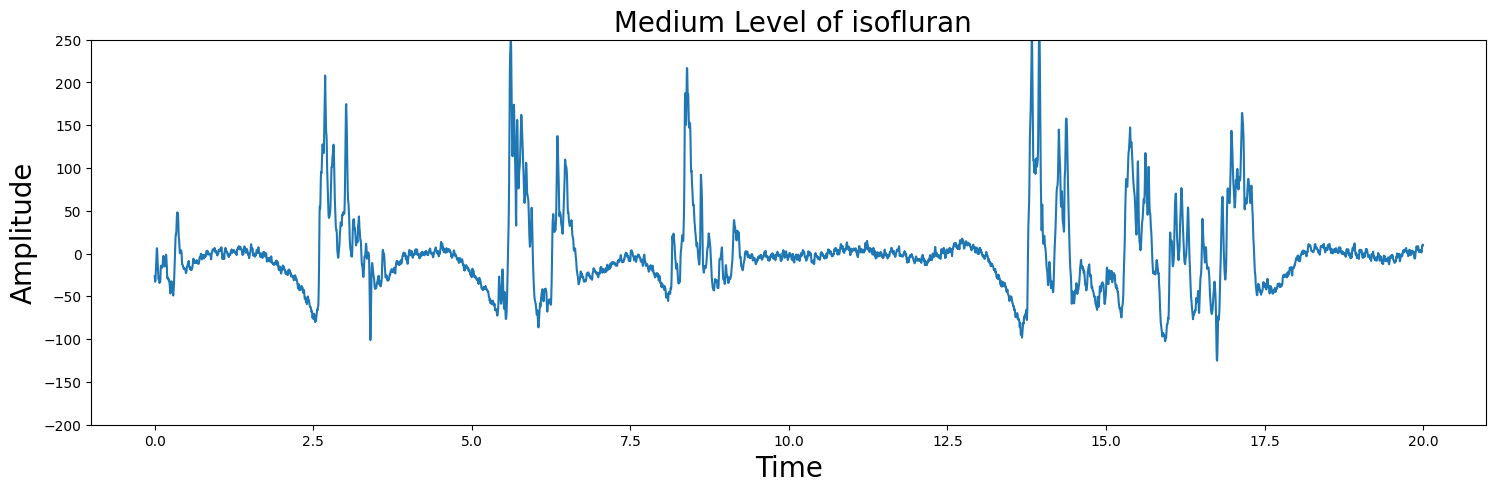

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title(' Medium Level of isofluran', size = 20)
plt.xlabel('Time', size = 20) 
plt.ylabel('Amplitude', size = 20) 
plt.ylim(-200,250)

plt.plot(np.arange(5000)/250 , mid_data[-7, 0, :5000])
plt.grid(False)
plt.savefig('SampleMedium.pdf', format='pdf', dpi=500)
plt.savefig('SampleMedium.png', format='png', dpi=700)

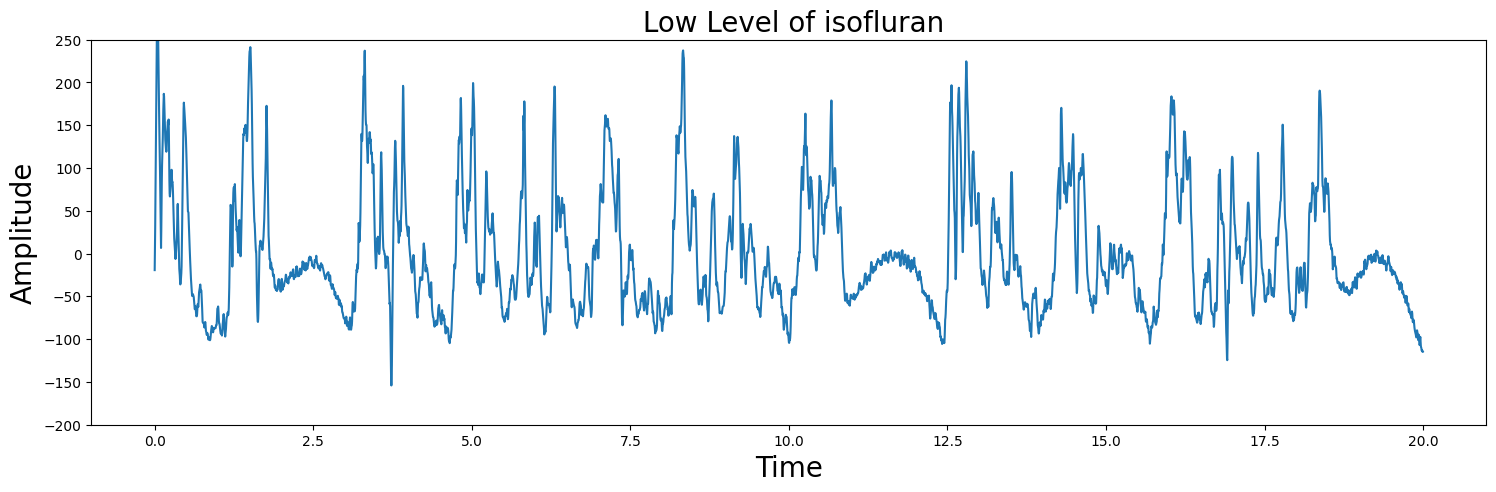

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title(' Low Level of isofluran', size = 20)
plt.xlabel('Time', size = 20) 
plt.ylim(-200,250)
plt.ylabel('Amplitude', size = 20) 

plt.plot(np.arange(5000)/250 , low_data[-4, 0, :5000])
plt.grid(False)
plt.savefig('Samplelow.pdf', format='pdf', dpi=500)
plt.savefig('Samplelow.png', format='png', dpi=700)